# SEPTA DELAY ANALYSIS

# Introduction

Approximately 119,000 daily riders take advantage SEPTA’s Regional Rail system, which provides service to the Philadelphia metropolitan area. The SEPTA (Southeastern Pennsylvania Transportation Authority) Regional Rail system consists of commuter rail service on 13 branches to more than 150 active stations in Philadelphia, Pennsylvania, and its suburbs and satellite cities.


SEPTA reports On-Time Performance (OTP) to measure service reliability. OTP identifies the number of trains for all rail lines that arrive at their scheduled destination at the scheduled time. However, by industry standard, a train may arrive up to 5 minutes and 59 seconds after its scheduled time and still be considered on-time. SEPTA has set an On-Time Performance target such that 91% of its trains arrive on time. Thus, even with 100% “on time” performance, trains may still arrive late, forcing commuters to deal with uncertainty and lost time – especially if they rely on back-to-back connections.


The blue lines in the map show all the regional rail line of SEPTA and the heart marker is our UPENN!


<img src="http://drive.google.com/uc?export=view&id=1x37x4B9RxtBsgRWhYzVg7dLZR8FcKQVW">


 

# Dataset
Here is the [main dataset](https://www.kaggle.com/septa/on-time-performance) on kaggle.com

In [0]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Dataset as downloaded from Kaggle
!unzip '/content/gdrive/My Drive/545/Project_545/on-time-performance.zip' 

In [0]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sqlite3
import datetime
import time

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from sklearn.metrics import mean_squared_error
from math import sqrt

import re
!pip install plotnine  
from pandas.api.types import CategoricalDtype
from plotnine import *
%matplotlib inline

# 1.0 Exploring SEPTA tweets

In [0]:
# installing required packages
!pip3 install -qq twint
!pip install -qq whatthelang

#twitter imports
import json
import csv
from datetime import date
from datetime import datetime
import time
import twint

## 1.1 TWINT API

[Twint](https://github.com/twintproject/twint) is an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter profiles without using Twitter's API. I used this tool to get all tweets from [@SEPTA](https://twitter.com/SEPTA), i.e. SEPTAs official twitter account.



In [0]:
# Instantiate and configure the twint-object
c = twint.Config()
c.Store_object = True
c.Pandas =True
c.Limit = 1000
c.Lang = 'en'
c.User_id = 16358930
c.Year = 2015

This tool uses various search parameters to filter the required tweets. The list of these parameters is [here](https://github.com/twintproject/twint/wiki/Basic-usage)

In [0]:
# Run search
twint.run.Search(c)

In [0]:
# Quick check
twint.storage.panda.Tweets_df.head(20)

In [0]:
# Quick Preprocessing tweets df
tweets = twint.storage.panda.Tweets_df.drop_duplicates(subset=['id'])
tweets.index = range(len(tweets))
septa_tweets = tweets[tweets['username'] == 'SEPTA']

In [0]:
# Saving the csv file
septa_tweets.to_csv('septa_tweets.csv',index = False, header=True)

## 1.2 Loading the dataset and visualization

In [0]:
# Twitter Dataset 
septa_tweets = pd.read_csv('/content/gdrive/My Drive/545/Project_545/septa_tweets.csv')
septa_tweets = septa_tweets[(septa_tweets['date'] > '2016-03-22 00:00:00') & (septa_tweets['date'] <= '2016-11-05 23:58:02')]
# removing some unwanted features
septa_tweets = septa_tweets.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'id',
                                            'conversation_id', 'created_at', 'reply_to'])

Lets see some of the tweets

In [0]:
# print 10 random tweets
from random import randint
for i in range(5):
  row_num = randint(0, 10000)
  print(septa_tweets.iloc[row_num]['tweet'])

Fox Chase: New schedules will be in effect Monday, Sept. 12 | Passengers can view the upcoming changes at  http://septa.org/service/contingency.html#interim …
Thorndale: Train #9538 going to Temple U is operating 15 minutes late. Last at Thorndale.
Doylestown: Train 3540 will operate express from Temple University to Lansdale.
Norristown: Train #3238 going to Elm St is operating 10 minutes late. Last at Miquon.
Fox Chase: Train #834 going to Fox Chase is operating 10 minutes late. Last at Olney.


## 1.3 Interesting format of SEPTA tweets, some common identifiable patterns...
 

Most of the tweets (about 75% - 80%) from the [@SEPTA](https://twitter.com/SEPTA) twitter account are in a specific schema/ format. To extract useable information from these tweets we could exploit this fact and break down the tweets into smaller chunks which could act as features to our model later.

### **Example tweet** - "Doylestown: Train #548 going to Link Belt is operating 10 minutes late. Last at Bryn Mawr."

Here we can see that the first word denotes the regional rail line which is Doylestown and the #548 gives the information about the train number, i.e. 548. 
The station name after string 'going to' is the terminal station of the train and determines the direction of the train, i.e. North - N or South - S. The numerals before the minutes string convey the time for which the train is delayed at a perticular stop. And finally, the last part of the tweet gives information about the previously visited station.

---

**TL;DR**
  
*   ':' seperates line name and message
*   Word 'Train ' precedes train number starting with '#'
*   ' minutes' string succeedes the time delay experienced
*   'Last at ' precesdes last visited station 

---

All tweets do not follow this particular pattern and some notable exceptions are analysed seperately.

Lets try and extract these features...


### 1.3.1 Function Class *twitter_processing*

In [0]:
class twitter_processing:

  def __init__(self):

    self.line_name = None
    self.message = None
    self.train_id = None
    self.minutes_late_after_split = None
    self.last_station = None



  def find_line_name(self, input_str):
    try:
      split_string = input_str.split(':', 1)
      self.line_name, self.message = split_string[0], split_string[1]
      return self.line_name
    except:
      return "NA"

  def find_message(self,input_str):
    try:
      split_string = input_str.split(': ', 1)
      self.line_name, self.message = split_string[0], split_string[1]
      return self.message
    except:
      return "NA"


  def find_train_id(self, input_str):
    self.message = self.find_message(input_str)
    if (self.message != 'NA'):
      try:
        start = self.message.find("Train #") + len("Train #")
        self.train_id = None
        self.train_id = int(self.message[start:].split(None, 1)[0])
        return self.train_id
      except:
        return 'NA'
    else:
      return 'NA'


  def find_delay_time(self, input_str):
    self.message = self.find_message(input_str)
    if (self.message != 'NA'):
      try:
        minutes_late_message = self.message.find(" minutes")
        self.minutes_late_after_split = None
        self.minutes_late_after_split = int(self.message[:minutes_late_message].rsplit(None, 1)[1])
        return self.minutes_late_after_split
      except:
        return "NA"
    else:
      return "NA"

  def find_last_station(self, input_str):
    self.message = self.find_message(input_str)
    if (self.message != 'NA'):
      try:
        last_at_string = self.message .split(' Last at ', 1)
        mini_message, last_station_with_dot = last_at_string[0], last_at_string[1]
        self.last_station = None
        self.last_station = last_station_with_dot[:-1]
        return self.last_station
      except:
        depart = self.message.find("scheduled to depart ") + len("scheduled to depart ")
        end = self.message.find(" at ")
        self.last_station = None
        self.last_station = self.message[depart:end]
        if (len(self.last_station) < 20):
          return self.last_station
        else:
          return 'NA'
    else:
      return "NA"

In [0]:
twt = twitter_processing()

septa_tweets['line_name'] = septa_tweets['tweet'].apply(lambda x : twt.find_line_name(x))
septa_tweets['train_id'] = septa_tweets['tweet'].apply(lambda x : twt.find_train_id(x))
septa_tweets['delay'] = septa_tweets['tweet'].apply(lambda x : twt.find_delay_time(x))
septa_tweets['last_station'] = septa_tweets['tweet'].apply(lambda x : twt.find_last_station(x))

## 1.4 Analysing exceptional tweets

In [0]:
exception_twts = septa_tweets[septa_tweets['line_name'] == 'NA']
all_exception_text = []
all_exception_text.append(str(exception_twts['tweet'].apply(lambda x : str(x))))
seperator = ', '
my_sep_str = seperator.join(all_exception_text)

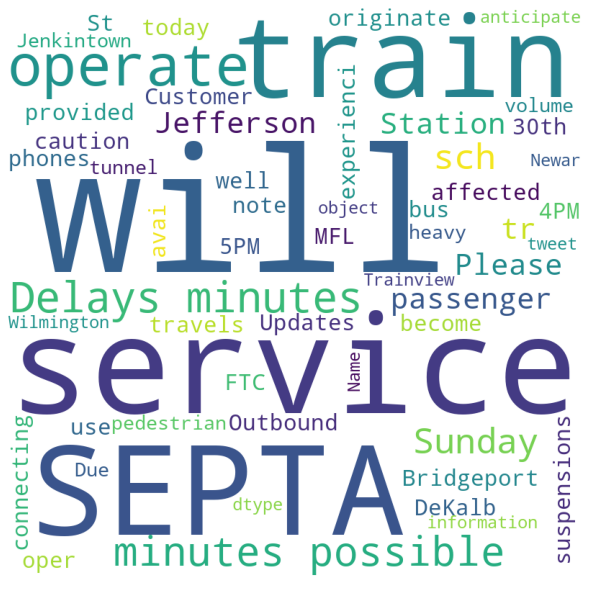

In [0]:
# Exception Word cloud
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(my_sep_str)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the word cloud we can see that the tweets non coforming to our predefined schema are mostly about future service updates. 

Words like - 'will', 'operate', 'service', etc suggest about some disruption about future work and hence they dont confine to our schema.

## 1.5 Tweets analysis

In [0]:
# drop these from main table  # ImP dont need exception twts in main dataset
new_septa_tweets = septa_tweets[septa_tweets.line_name != 'NA']

### Lets get some visualisation from tis data # new_septa_tweets

#### 1.5.1 Top 10 Regional Rail Lines occuring in septa tweets

In [0]:
important_lines = pd.DataFrame(new_septa_tweets.line_name.value_counts()[:10]).reset_index()

important_lines = important_lines.rename(columns={"index" : 'line_name', 'line_name' : 'tweet_count'})
fig = px.bar(important_lines, x='line_name', y='tweet_count',
             hover_data=['tweet_count'], color='tweet_count',
             height=400)
fig.update_layout(
    title="Count of tweets for various regional lines in Twitter data",
    xaxis_title="Regional Rail Lines",
    yaxis_title="Count of tweets for (March to November)",
    font=dict(
        family="Times, monospace",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

Given that [@SEPTA](https://twitter.com/SEPTA) tweets only when there is any delay observed, the probability that a given train would be delayed seems to be more on the Thorndale line compared to oter regional lines as its tweet count is considerably more.

#### 1.5.2 Day of week wise Tweet frequency analysis

In [0]:
important_lines = new_septa_tweets[['day', 'line_name']].groupby(['line_name', 'day']).size().reset_index(name='counts')

# important_lines
import functools
def conjunction(*conditions):
    return functools.reduce(np.logical_or, conditions)

c_1 = important_lines.line_name == 'Thorndale'
c_2 = important_lines.line_name == 'Doylestown'
c_3 = important_lines.line_name == 'Elwyn'
c_4 = important_lines.line_name == 'Norristown'

to_plot = important_lines[conjunction(c_1,c_2,c_3,c_4)][['line_name', 'day', 'counts']]
to_plot['day'] = to_plot['day'].map({1 : 'Monday', 2 : "Tuesday", 3 : 'Wednesday',
                                     4 : 'Thursday', 5 : 'Friday', 6 : 'Saturday', 7 : 'Sunday'}) 
fig = px.scatter(to_plot, x='line_name', y='counts', color='counts',
                facet_col='day', facet_col_wrap=4)
fig.show()

For the four major regional rail routes, here we see that Saturday and Sunday have usually low tweet counts suggesting reduced rail activity during weekends, resulting in low traffic related delays

#### 1.5.3 Regional Line wise identified delay in tweets

In [0]:
# 1. drop rows having NA in delay column
new_delay_septa_tweets =  new_septa_tweets[new_septa_tweets.delay != 'NA']
new_delay_septa_tweets['delay'] = new_delay_septa_tweets['delay'].astype(float) 
new_delay_septa_tweets_to_plot = new_delay_septa_tweets[['line_name', 'delay']].groupby('line_name').mean().sort_values(by='delay').reset_index()

fig = px.bar(new_delay_septa_tweets_to_plot, x='line_name', y='delay',
             hover_data=['delay'], color='delay',
             height=400)

fig.update_layout(
    title="Average delays for various regional lines in Twitter data",
    xaxis_title="Regional Rail Lines",
    yaxis_title="Average Delay in Minutes",
    font=dict(
        family="Times, monospace",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

Rte 125 is the only excetion here, on an average all lines have about 15 minutes delay, for the tweets. The reason for such high average delays in evident in the next visualisation.

#### 1.5.4 Delays on Major Routes

In [0]:
# # Add histogram data
x1 = list(new_delay_septa_tweets[new_delay_septa_tweets.line_name == 'Thorndale']['delay'])
x2 = list(new_delay_septa_tweets[new_delay_septa_tweets.line_name == 'Doylestown']['delay'])
x3 = list(new_delay_septa_tweets[new_delay_septa_tweets.line_name == 'Elwyn']['delay'])
x4 = list(new_delay_septa_tweets[new_delay_septa_tweets.line_name == 'Norristown']['delay'])

counts, bins = np.histogram(x1, bins=range(5, 35, 1))
bins = 0.5*(bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Thorndale', 'y':'count'})
fig.show()

counts, bins = np.histogram(x2, bins=range(5, 35, 1))
bins = 0.5*(bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Doylestown', 'y':'count'})
fig.show()

counts, bins = np.histogram(x3, bins=range(5, 35, 1))
bins = 0.5*(bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Elwyn', 'y':'count'})
fig.show()

counts, bins = np.histogram(x4, bins=range(5, 35, 1))
bins = 0.5*(bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Norristown', 'y':'count'})
fig.show()

hist_data = [x1,x2,x3,x4]
group_labels = ['Thorndale', 'Doylestown', 'Elwyn', 'Norristown']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=[1, 1, 1, 1])
fig.show()

All the bar plots follow roughly same patterns, interesting find here is that, there are no tweets for trains which are late for less than 10 minutes. Hence average delay above was too high.

Delay in tweets follow some pattern, generally they like to tweet delay times in multiples of 5 , we can see bin for 10 minutes being the highest
and also for 15, 20, 25 relatively higher than their neighbours. This can not be normally occuring case.

## 1.6 Feature Engineering

In [0]:
septa_tweets['month'] = pd.DatetimeIndex(septa_tweets['date']).month
septa_tweets['day'] = pd.DatetimeIndex(septa_tweets['date']).day
# septa_tweets['hour'] = pd.DatetimeIndex(septa_tweets['date']).hour
septa_tweets['time'] = pd.DatetimeIndex(septa_tweets['date']).time


septa_tweets['second'] = septa_tweets['time'].apply(lambda x : str(x).split(':', 2)[2])  
septa_tweets['minute'] = septa_tweets['time'].apply(lambda x : str(x).split(':', 2)[1])    
septa_tweets['hour'] = septa_tweets['time'].apply(lambda x : str(x).split(':', 2)[0])    
septa_tweets = septa_tweets.drop(columns = ['date', 'tweet', 'time'])

In [0]:
# no NA values , reduces dataset size
septa_tweets = septa_tweets[septa_tweets['line_name'] != 'NA']
septa_tweets = septa_tweets[septa_tweets['train_id'] != 'NA']
septa_tweets = septa_tweets[septa_tweets['delay'] != 'NA']
septa_tweets = septa_tweets[septa_tweets['last_station'] != 'NA']

In [0]:
septa_tweets = septa_tweets[['month','day','hour','minute','second', 'line_name',
                             'train_id', 'delay', 'last_station', 
                             'nlikes','nreplies', 'nretweets']]

# 2.0 What about the weather?

Planned to use [Dark Sky](https://darksky.net/dev) API to pull Weather data 

But they sold this API to [Apple](https://www.apple.com/) and subsequently it closed its services recently on March 31,2020. Sigh!

 It could fetch weather details like rainfall, snow , temperature (min , max), wind, etc for any given cordinates for any date. Would have been very helpful in predicitng delay


 Git link - https://github.com/ZeevG/python-forecast.io

Luckily found [this](https://www.ncdc.noaa.gov/cdo-web/search) website, to provide me with weather data for Philly of 2016. This data is not for each coordinates in our dataframe but for Philadelphia. We can assume that it remains almost constant in and arround philly.

The erractic weather pattern (sudden drops in mercury) have a great impact on public as well as regional rail service .

In [0]:
weather_df = pd.read_csv('/content/gdrive/My Drive/545/Project_545/temp_phl.csv', header='infer')

weather_df['day'] = pd.DatetimeIndex(weather_df['Day']).day
weather_df['month'] = pd.DatetimeIndex(weather_df['Day']).month
weather_df['year'] = 16
# weather_df = weather_df.drop(columns='Day')
weather_df = weather_df.dropna()
weather_df.to_csv('weather_df.csv',index = False, header=True)
# to be used for ML

In [54]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=weather_df['Day'], y=weather_df['Max'],
                    mode='lines',
                    name='Max Temperature'))
fig.add_trace(go.Scatter(x=weather_df['Day'], y=weather_df['Min'],
                    mode='lines',
                    name='Min Temperature'))
fig.show()

I anticipate that bad/ adverse weather will result in delays. Time of day (commute vs. non-commute hours), and time of year (slippery rail season) will all be strongly predictive variables in the likelihood at train is delayed. Hence I decided to pull up this data and append it to my training data for my model.

# 3.0 Working with kaggle data

Kaggle had two csv files for ths dataset otp.csv and trainView.csv

This “otp.csv” from the Kaggle dataset contains On-Time Performance information as from 23 March, 2016 to 6 November, 2016 :


*   train_id
*   direction ('N' or 'S' direction is demarcated as either Northbound or Southbound)
*   origin ('Warminster', 'Glenside',...'Airport Terminal..')
*   next_station (Think of this as the station stop, at timeStamp)
*   date
*   status ('On Time', '5 min', ... This is a status on train lateness. 999 is a suspended train)
*   timeStamp



Note as per the dataset, only 32% of trains run perfectly “on-time”, with another 30% running 1-3 minutes late and the remaining ~1/3 of the trains running >3 minutes late


## 3.1 Cleaning data



In [0]:
def status_modify(given_str):

  if (str(given_str) == 'On Time'):
    return str(given_str).replace("On Time", '0')
  else:
    return str(given_str).replace(" min", '')

In [0]:
# Clean train_id 
otp_df = pd.read_csv('/content/otp.csv')
# remove any special character or alphabets from train_id.
otp_df['train_id'] = otp_df['train_id'].apply(lambda x : re.sub("[^0-9/-/.]", "", str(x)))

# status_modified is time in minutes
otp_df['status_modified_minutes'] = otp_df['status'].apply(lambda x : status_modify(str(x)) )
otp_df['status_modified_minutes'] = otp_df['status_modified_minutes'].astype(int)
otp_df = otp_df.drop(columns= 'status')

otp_nona =  otp_df[otp_df.origin != 'None']
otp_nona =  otp_nona[otp_nona.next_station != 'None']

Interesting fact: Trains going south (S) have odd train_id values and North (N) have even.

In [0]:
# Splitting the date into day, month , year and finding day_of_week
otp_date_df= otp_nona['date'].str.split("-", n = 2, expand = True) 

otp_nona["month"]= otp_date_df[1].astype(int) 
otp_nona["day"]= otp_date_df[2].astype(int) 
data_df = None

otp_nona['day_of_week'] = otp_nona.apply(lambda x : datetime.datetime(2020,x.month,x.day).weekday(), axis=1)
otp_df = otp_nona
otp_time_df = otp_df['timeStamp'].str.split(" ", n = 1, expand = True) 

In [0]:
# SPliting time column to find hours, minutes, seconds resp.
otp_df['time'] = otp_time_df[1].astype(str) 
otp_time_df = None
otp_times_df= otp_df['time'].str.split(":", n = 2, expand = True)
otp_df["sec"]= otp_times_df[2].astype(int) 
otp_df["min"]= otp_times_df[1].astype(int) 
otp_df["hour"]= otp_times_df[0].astype(int) 
otp_df = otp_df.drop(columns=['timeStamp', 'month','time','sec']) 

# Scaling the minutes column from 0-59 to 0 - 19 as make a new categorical variable. 
# 3 minute window , is apt to capture the small variations in timings and also gives less 
# ... number of fetures to work with.
otp_df["min_scaled"]= otp_df["min"].apply(lambda x : math.ceil(int(x) / 3))
otp_df = otp_df.drop(columns=['min']) 
otp_df['month'] = otp_nona["month"]

In [0]:
otp_df = otp_df[pd.to_numeric(otp_df['train_id'], errors='coerce').notnull()]
otp_df = otp_df[pd.to_numeric(otp_df['status_modified_minutes'], errors='coerce').notnull()]
otp_df = otp_df[pd.to_numeric(otp_df['day_of_week'], errors='coerce').notnull()]
otp_df = otp_df[pd.to_numeric(otp_df['hour'], errors='coerce').notnull()]
otp_df = otp_df[pd.to_numeric(otp_df['min_scaled'], errors='coerce').notnull()]

In [0]:
# Only working with trains which ran atleast 100 times in 9 months period.
counts = otp_df.train_id.value_counts()

otp_df_new = otp_df[~otp_df['train_id'].isin(counts[counts < 100].index)]
otp_df_new = otp_df_new[['month', 'date', 'day', 'day_of_week', 'hour', 'min_scaled', 'origin',
                         'direction','train_id', 'status_modified_minutes', 'next_station']]

In [0]:
# Saving the csv 
otp_df_new.to_csv('otp_df_new.csv',index = False, header=True)

## 3.2 Interesting plot for On Time Performance data

Plot showing spread of delay times for Thorndale and Norristown(Elm St) line in the otp dataset. Here a comparision between different line could not be plot due to size of dataset.

In [13]:
# # Add histogram dat
x1 = list(otp_df[otp_df.origin == 'Thorndale']['status_modified_minutes'])
x4 = list(otp_df[otp_df.origin == 'Elm St']['status_modified_minutes']) # Norristown line is name as Elm st in otp database, different from twitter


hist_data = [x1,x4]
group_labels = ['Thorndale', 'Norristown']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=[1, 1])
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [70]:
# View for thorndale
thorndale_df = otp_df_new[otp_df_new['origin'] == 'Thorndale']
fig = px.line(thorndale_df, x='date', y='status_modified_minutes')
fig.show()

In [71]:
# View for Wayne
thorndale_df = otp_df_new[otp_df_new['origin'] == 'Wayne']
fig = px.line(thorndale_df, x='date', y='status_modified_minutes')
fig.show()

## 3.3 TrainView dataframe

trainView.csv - GPS Train data (early release)

GPS coordinates are based on track telemetry.

  * train_id
  * status
  * next_station
  * service
  * dest
  * lon
  * lat
  * source
  * track_change
  * track
  * date
  * timeStamp0 First timeStamp at coordinates.
  * timeStamp1 Last timeStamp at coordinates.

In [0]:
# given csv Datasets
trainView_df = pd.read_csv('/content/trainView.csv', low_memory=False)

In [0]:
# status ('On Time', '5 min', '10 min'. This is a status on train lateness. 999 is a suspended train)
suspended_df = trainView_df[trainView_df.status == '999']
# Trains for the source-dest pair were suspended most
to_view_suspended = suspended_df[['source', 'dest']]
to_view_suspended['route'] = to_view_suspended['source'].astype(str) + str(' - ') + to_view_suspended["dest"].astype(str)
to_view_suspended = to_view_suspended.drop(columns = ['source', 'dest']).reset_index().drop(columns = ['index'])
agg_df_suspended = to_view_suspended.groupby('route').size().sort_values(ascending=False)[:20]
agg_df_suspended = pd.DataFrame(agg_df_suspended).reset_index().rename(columns = {0 : 'count'})

In [43]:
# Shows which route has most number of cancellations of train journeys 
fig = px.bar(agg_df_suspended, x='route', y='count',
             hover_data=['count'], color='count',
             height=400)



fig.update_layout(
    title="Count of instances for suspended regional lines train services(TOP 20)",
    xaxis_title="Regional Rail Routes (Source - Destination)",
    yaxis_title="Count of suspended journeys for (March to November)",
    font=dict(
        family="Times, monospace",
        size=12,
        color="#7f7f7f"
    )
)

fig.show()

## 3.4 More Visual Analysis

In [0]:
agg_otp_df = otp_df.groupby(by = 'status_modified_minutes').count()[['train_id']]
agg_otp_df['percentage'] = agg_otp_df['train_id'].apply(lambda x : x/1882015)
agg_otp_df['minutes'] = agg_otp_df.index

/usr/local/lib/python3.6/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning:

geom_path: Removed 111 rows containing missing values.



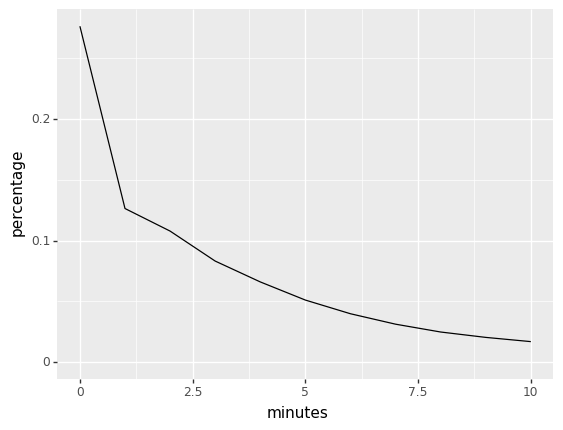

<ggplot: (-9223363257428582996)>

In [56]:
(ggplot(agg_otp_df, aes(x='minutes', y='percentage')) +
  geom_line() +
  xlim(0,10))

The above plot shows the percentage of delays reported in trainView.csv for given number of minutes. Evidently, the trains are mostly on-time, roughly 30 % with zero delay. SEPTA doesnot consider a train as late till it arrives less than 6 minutes late.

# 4.0 Machine Learning

In this section we would like to determine the delays in the OPT dataset. We could combine weather data with the on-time performance data and see its effect too. The aim of this section would be to be able to predict the delays in the SEPTA regional rail system.


In [0]:
## ML start:
otp_df_new = otp_df_new.drop(columns = 'date')
# Merge weather data
merged_df = weather_df.merge(otp_df_new, how='outer', left_on=["month", "day"], right_on=["month","day"])
merged_df = merged_df.drop(columns = ['day', 'year'])
merged_df = merged_df.dropna()
X = merged_df.drop(columns = 'status_modified_minutes').astype(object)
Y = merged_df[['status_modified_minutes']]

# Do get_dummy
cols_to_do = ['month','day_of_week','hour','min_scaled','origin','direction','train_id',	'next_station']
merged_df_dummy = pd.get_dummies(X, columns = cols_to_do)



In [0]:
# concat data and labels
merged_df_dummy = pd.concat([merged_df_dummy, Y], axis=1, sort=False)

In [0]:
# Sample randomly 
train_data = merged_df_dummy.sample(n = 100000) 
test_data =  merged_df_dummy.sample(n = 10000)

In [0]:
train_Y = train_data.iloc[:,-1]
test_Y = test_data.iloc[:,-1]

train_Y = np.asarray(train_Y).flatten()
test_Y = np.asarray(test_Y).flatten()

train_data = train_data.iloc[:,:-1]
test_data = test_data.iloc[:,:-1]

Random forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
parameters = {'n_estimators':[50,100,150], 'max_depth': [10,20,30]}

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, verbose = True, scoring = 'r2')
grid.fit(train_data, train_Y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

In [0]:
# Getting predictions for both train and test set
y_pred = grid.predict(test_data)
y_pred_train = grid.predict(train_data)

In [39]:
# Find the RMSE 
print("RMSE for test set is  -  ", np.sqrt(mean_squared_error(test_Y, y_pred)))
print("RMSE for training set is  -  ",np.sqrt(mean_squared_error(train_Y, y_pred_train)))

RMSE for test set is  -   14.205311014137576
RMSE for training set is  -   9.49803243636742


A close enough rmse value suggest that the model is well trained, the rmse are not between 0-1 or standardised because 3 features were not normalised before.

The machine learing results provide a strong case for predicting future delays for regional rail lines